# Question 1

Files are first 11 lines that present the initial parameters there is one line by obstacles which is represented by 4 numbers.
One can first check that the file is made of at least 11 lines consisting of only one number, then check than any further line is made of group of 4 and finaly that coordinates belong to (0,O, xmin, xmax)


In [120]:
def parse(filename : str):
    '''
    Takes a filename and return a list of :
    5 tupple (x_max, y_max) , u_s1, u_d1, u_s2, u_d2
    a float R
    and a list of obstacles which are represented by a tupple (xo,yo,ℓx,ℓy )
    elements by obstacle
    '''
    with open(filename, "r") as f:
        lines = f.readlines() 

    ## check that f is well defined
    if (len(lines)) < 11: # f must contain at least 11 lines
        raise ValueError("Invalid input")
    for line in lines:
        line = line.strip()

    for line in lines[0:11]:
        try:
            (line) = float(line)
        except ValueError:
            raise ValueError("Invalid input")
    for line in lines[11:]:
        line = line.split()
        if len(line) != 4:
            raise ValueError("Invalid input")
        for number in line:
            try:
                (number) = float(number)
            except ValueError:
                raise ValueError("Invalid input")
    # we know that f is well structured we can now parse it
    coordinates_max = (float(lines[0]), float(lines[1]))
    u_s1 = (float(lines[2]), float(lines[3]))
    u_d1 = (float(lines[4]), float(lines[5]))
    u_s2 = (float(lines[6]), float(lines[7]))
    u_d2 = (float(lines[8]), float(lines[9]))

    R = float(lines[10])

    obstacles : list[tuple[float]] = []
    for line in lines[11::]:
        line = line.split()
        obstacles.append(tuple(float(x) for x in line))

    return [coordinates_max, u_s1, u_d1, u_s2, u_d2, R, obstacles]




In [121]:
filename_test :str = "scenarios/scenario4.txt"
parsed = parse(filename_test)

# Question 2

In [122]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.axes import Axes
from matplotlib.figure import Figure

OUTLINE_COLOR = "red"
FILL_COLOR = "black"
WHITE = (255, 255, 255, 0)

def create_image(dimension : tuple[float, float]):
    fig, ax  = plt.subplots(figsize = (10, 10))
    ax.set_xlim(0, dimension[0])
    ax.set_ylim(0, dimension[1])

    return fig, ax


def print_obstacle(obstacle : tuple[float, float, float, float],  ax : Axes):
    rect = patches.Rectangle(
        (obstacle[0], obstacle[1]),  
        obstacle[2],                 
        obstacle[3],                
        facecolor=FILL_COLOR,
        edgecolor=OUTLINE_COLOR
    )
    

    ax.add_patch(rect)

def print_vertex(departure : tuple[float, float], arrive : tuple[float, float], ax : Axes):
    x_coords = [departure[0], arrive[0]]
    y_coords = [departure[1], arrive[1]]
    
    line = mlines.Line2D(x_coords, y_coords, color=OUTLINE_COLOR, linewidth=3)
    ax.add_line(line)

def print_obstacles(obstacles: list[tuple[float, float, float, float]], ax: Axes):
    for obstacle in obstacles:
        print_obstacle(obstacle, ax)

def print_path(vertices: list[list[tuple[float, float]]], ax: Axes):
    for vertex_pair in vertices:

        print_vertex(vertex_pair[0], vertex_pair[1], ax)



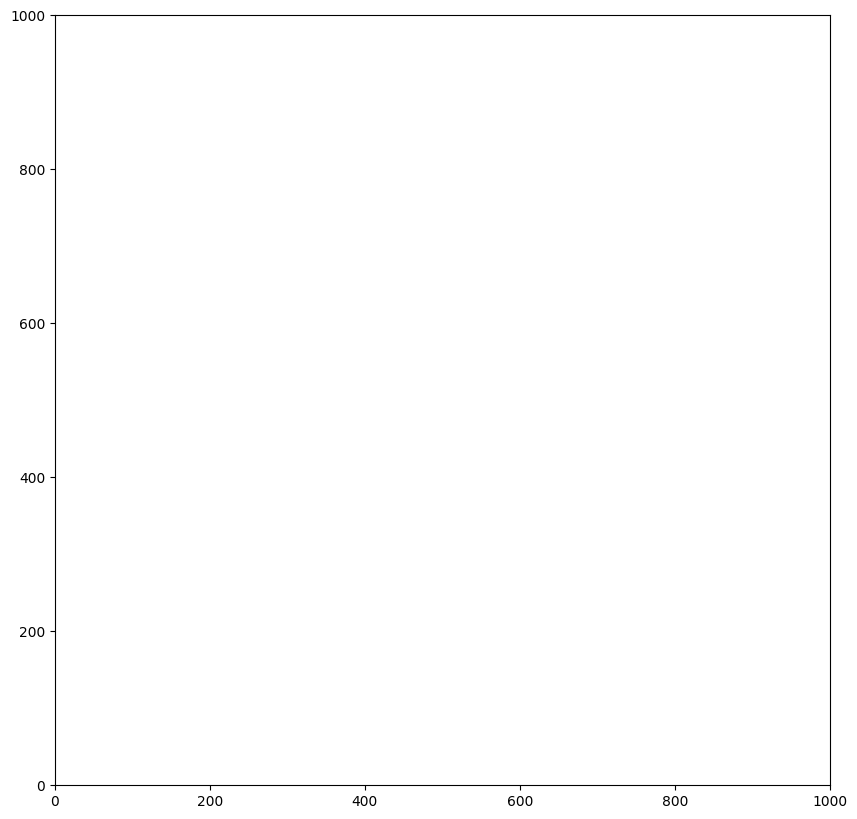

In [123]:

coordinates_max, u_s1, u_d1, u_s2, u_d2, R, obstacles = parsed
fig,ax = create_image(coordinates_max)

In [124]:
print_obstacles(obstacles, ax)


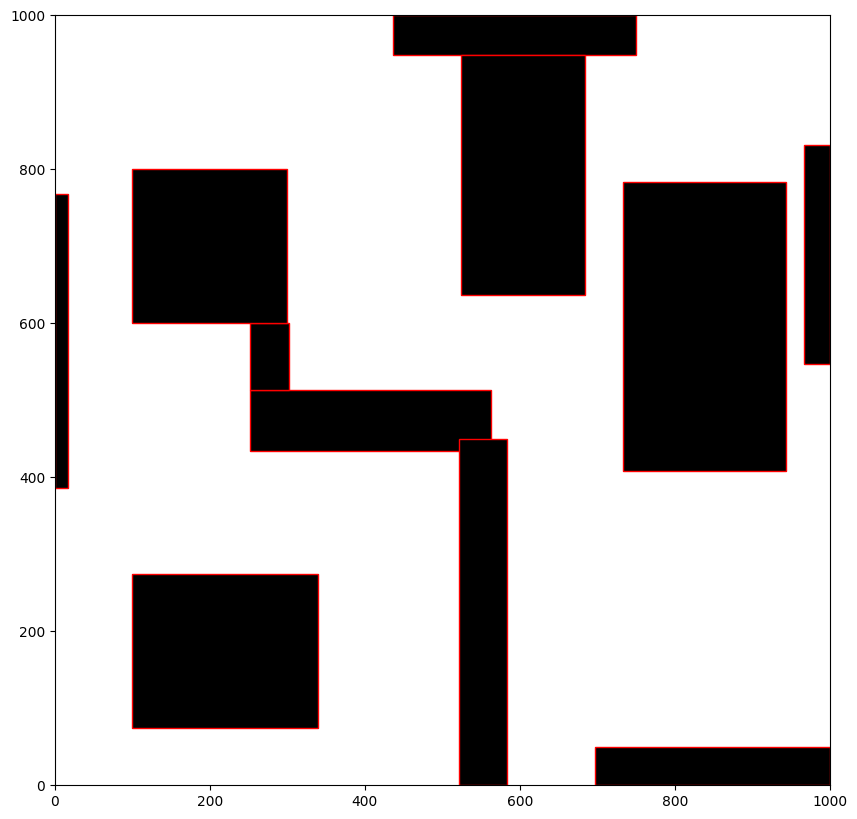

In [125]:
display(fig)

# Question 3

Dans notre problème, une particule correspond à un test de chemin et la fonction fitness pourrait être l'écart en vol d'oiseau à l'arrivé.
On peut envisager différentes structures de données, mais afin d'avoir un maximum de particules et de pouvoir parraléliser les calculs le plus efficace serait de stocker dans 3 arrays différents contenants positions, vitesses, meilleur minima local

# Question 4 
On peut pour chaque arrête sur le graphe tester si elle collisione avec chaque arrete des rectangles 